## 必备函数

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque, Counter
import time

## WS小世界模型、NW小世界模型、无标度网络模型 实现

In [10]:
def nearest_neighbor_network(num_nodes: int, k: int):
    assert k % 2 == 0, "K must be an even number"

    g = nx.Graph()
    for offset in range(1, k // 2 + 1):
        g.add_edges_from(
            np.hstack(
                [
                    np.vstack(
                        [np.arange(num_nodes), np.roll(np.arange(num_nodes), -offset)]
                    ),
                    np.vstack(
                        [np.arange(num_nodes), np.roll(np.arange(num_nodes), offset)]
                    ),
                ],
            ).T
        )

    return g


def ws_small_work(g: nx.Graph, p: float):

    assert 0 <= p <= 1, "Probability p must be between 0 and 1."

    small_world = g.copy()
    for u, u_nbrs in g.adj.items():
        for neighbor in u_nbrs:
            if np.random.random() < p:
                possible_nodes = list(set(g.nodes) - set(g[u]) - {u})
                if len(possible_nodes) > 0:
                    if small_world.has_edge(u, neighbor):
                        small_world.remove_edge(u, neighbor)
                        v = np.random.choice(possible_nodes)
                        while small_world.has_edge(u, v):
                            v = np.random.choice(possible_nodes)
                        small_world.add_edge(u, v)

    return small_world

def nw_small_work(g: nx.Graph, p: float):

    assert 0 <= p <= 1, "Probability p must be between 0 and 1."

    small_world = g.copy()
    for u in g.nodes:
        for v in g.nodes:
            if u != v and not g.has_edge(u, v):
                if np.random.random() < p:
                    small_world.add_edge(u, v)
    return small_world


## 平均路径长度和聚类系数

In [11]:
def average_shortest_path_length(g):
    n = len(g)
    return sum(
        l for s in g for l in nx.single_source_shortest_path_length(g, s).values()
    ) / (n * (n - 1))


def average_clustering(g):
    def triangle_degree_iter():
        for u, u_nbrs in g.adj.items():
            u_nbrs = set(u_nbrs) - {u}  # remove self-loop if exists
            gen_degree = Counter(len(u_nbrs & (set(g[v]) - {v})) for v in u_nbrs)
            num_triangles = sum(k * val for k, val in gen_degree.items())
            yield (len(u_nbrs), num_triangles)

    return sum(
        0 if T == 0 else T / (deg * (deg - 1)) for deg, T in triangle_degree_iter()
    ) / len(g)

## 展示

In [15]:
num_nodes = 10
k = 4 # for nearest neighbor coupled network
p = 0.1

def show_graph(g):
    nx.draw(g, pos = nx.circular_layout(g))
    plt.show()
    # verify the correctness of our implementation
    assert average_shortest_path_length(g) == nx.average_shortest_path_length(g)
    assert average_clustering(g) == nx.average_clustering(g)

    print(f"Average shortest path length: {average_shortest_path_length(g)}")
    print(f"Average clustering coefficient: {average_clustering(g)}")

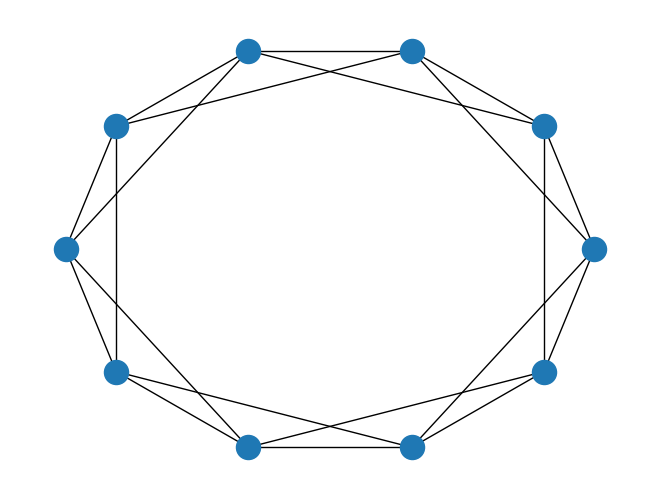

Average shortest path length: 1.6666666666666667
Average clustering coefficient: 0.5


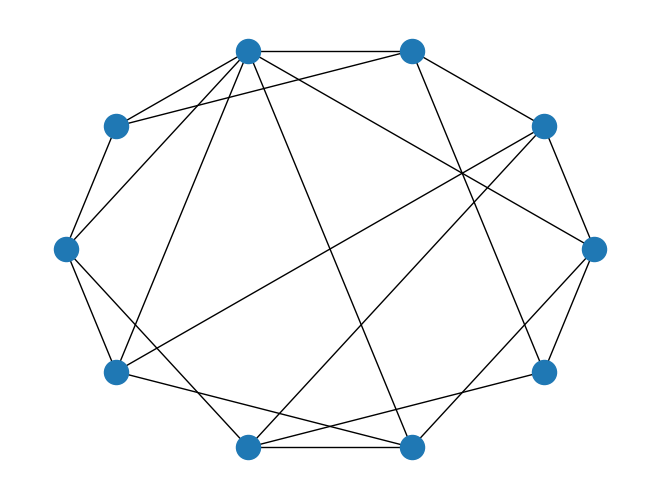

Average shortest path length: 1.5777777777777777
Average clustering coefficient: 0.2333333333333333


In [17]:
g = nearest_neighbor_network(num_nodes, k)
show_graph(g)
ws = ws_small_work(g, p)
assert g.number_of_edges(), ws.number_of_edges()
show_graph(ws)

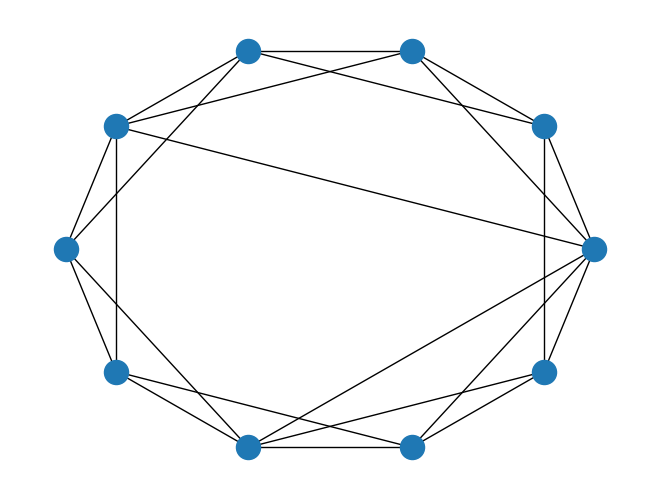

Average shortest path length: 1.5555555555555556
Average clustering coefficient: 0.53


In [14]:
show_graph(nw_small_work(g, p))

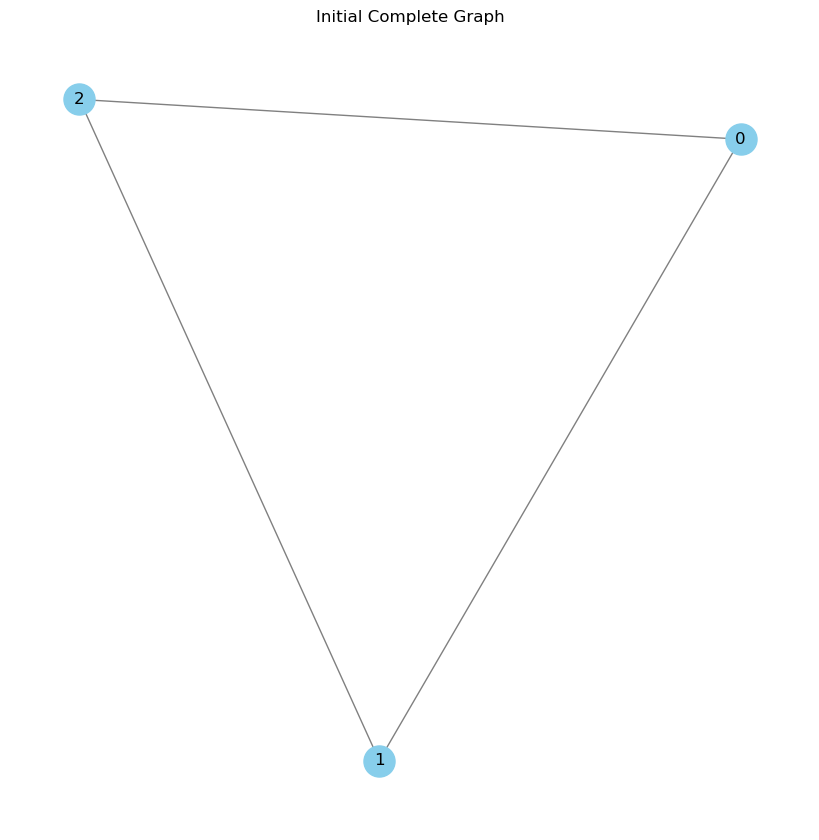

Initial Complete Graph - Avg Path Length: 1.0, Avg Clustering Coefficient: 1.0
After adding node 4 - Avg Path Length: 1.0, Avg Clustering Coefficient: 1.0


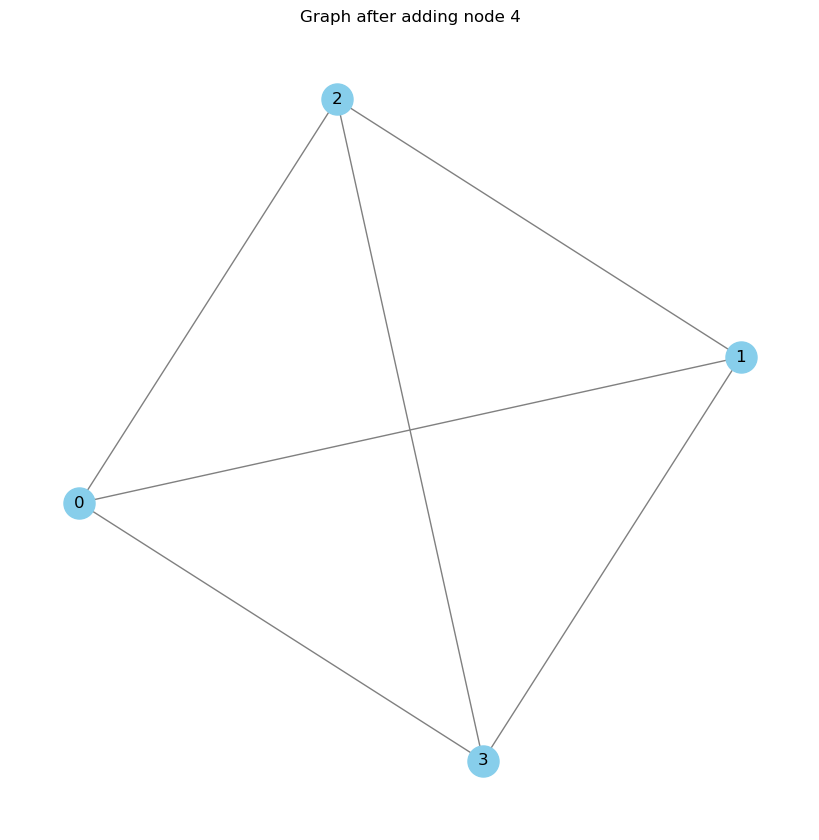

After adding node 5 - Avg Path Length: 1.1, Avg Clustering Coefficient: 0.9


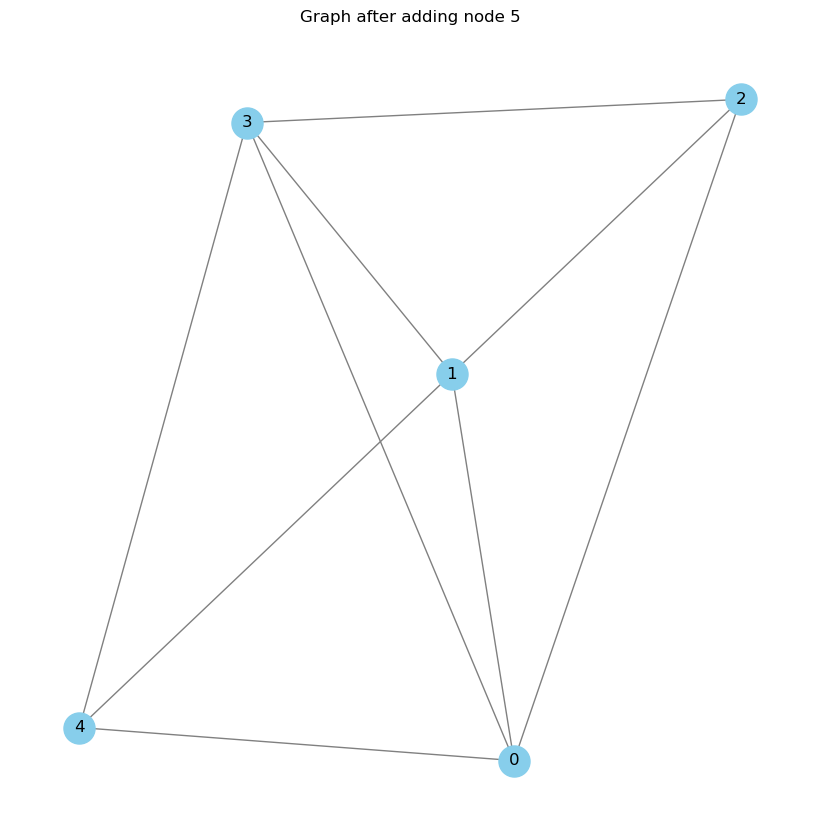

After adding node 6 - Avg Path Length: 1.2, Avg Clustering Coefficient: 0.8444444444444444


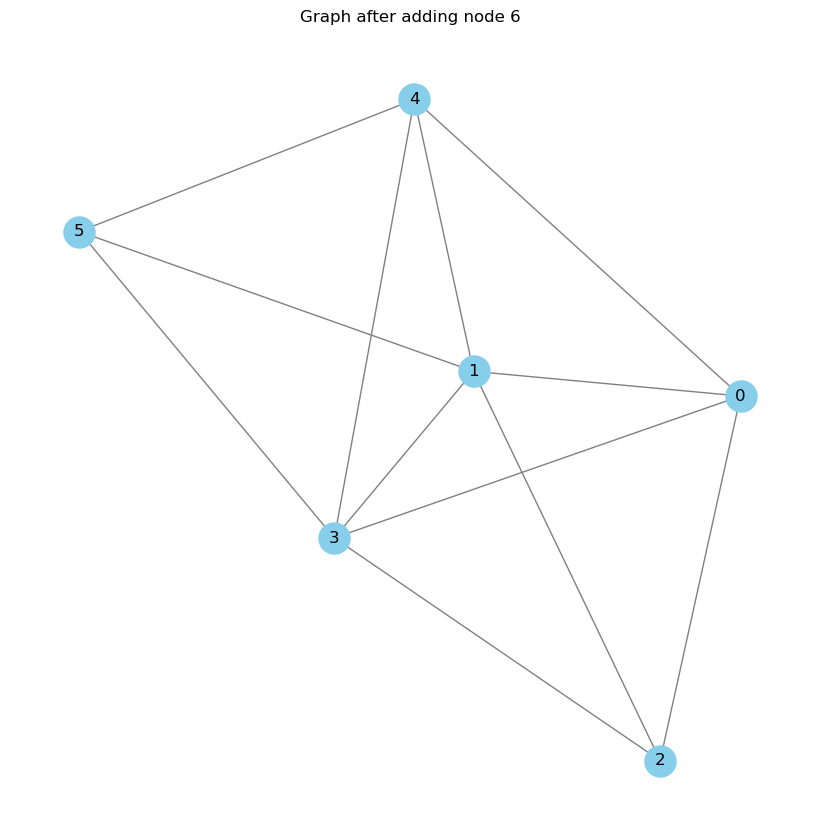

After adding node 7 - Avg Path Length: 1.2857142857142858, Avg Clustering Coefficient: 0.7095238095238096


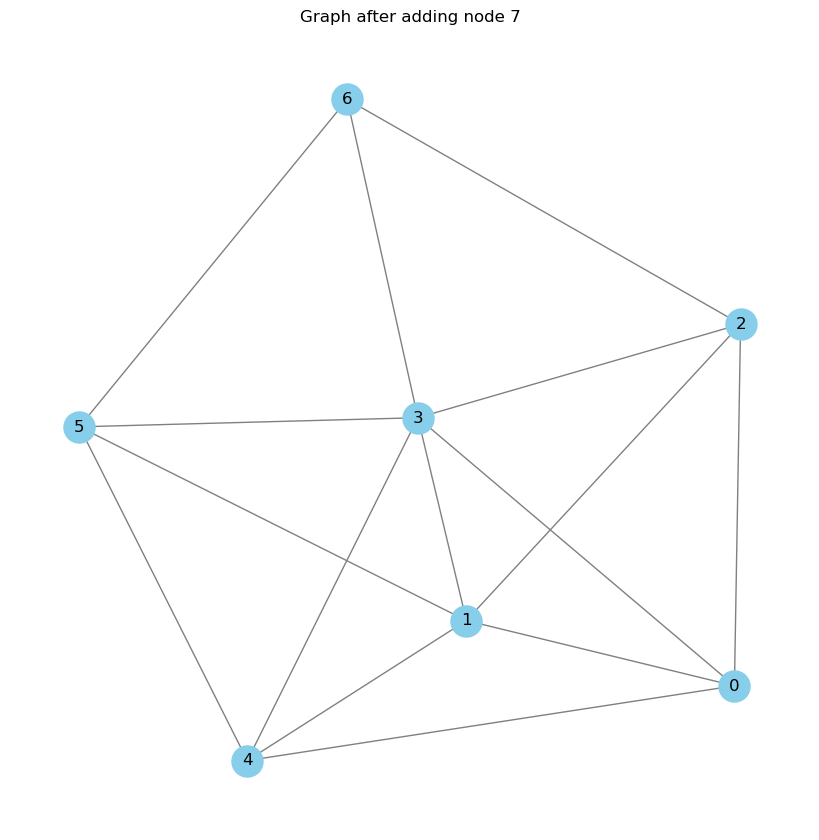

After adding node 8 - Avg Path Length: 1.3571428571428572, Avg Clustering Coefficient: 0.6446428571428572


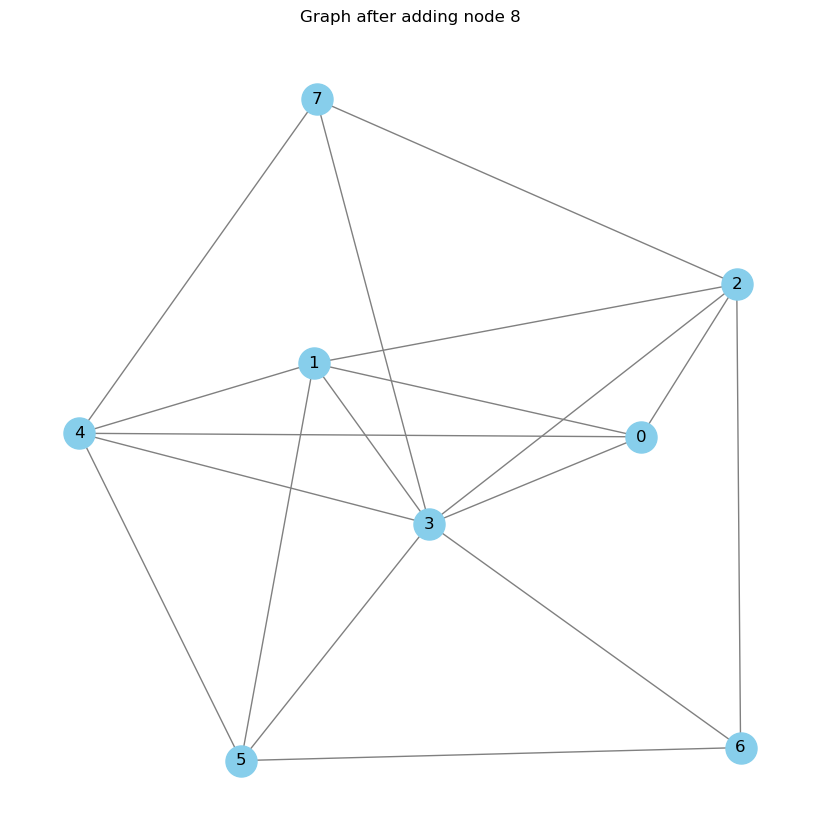

After adding node 9 - Avg Path Length: 1.4166666666666667, Avg Clustering Coefficient: 0.5396825396825397


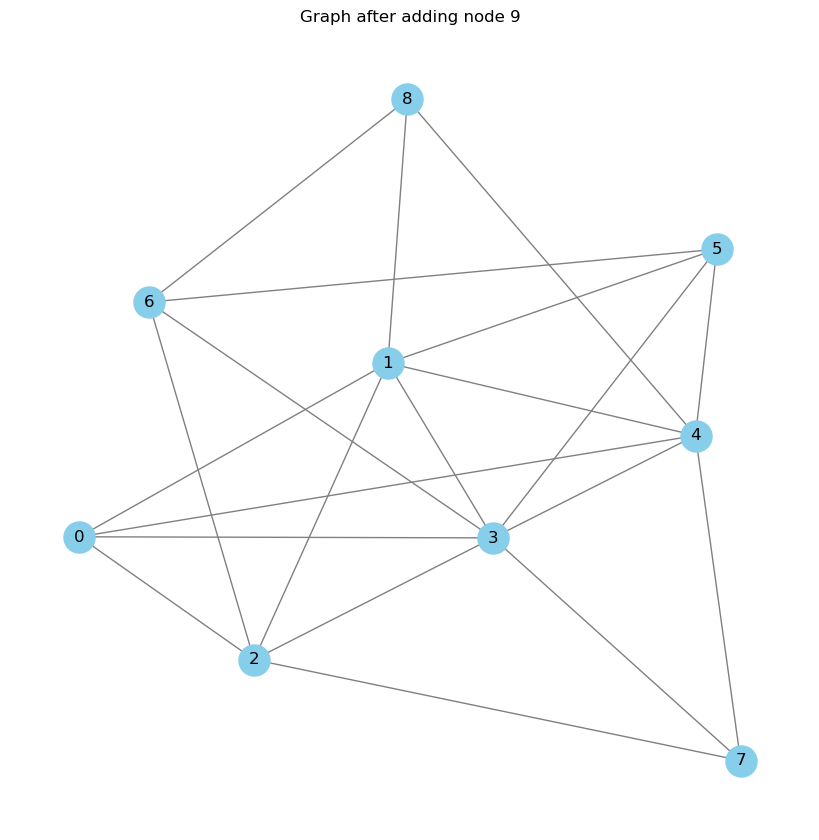

After adding node 10 - Avg Path Length: 1.488888888888889, Avg Clustering Coefficient: 0.4519047619047619


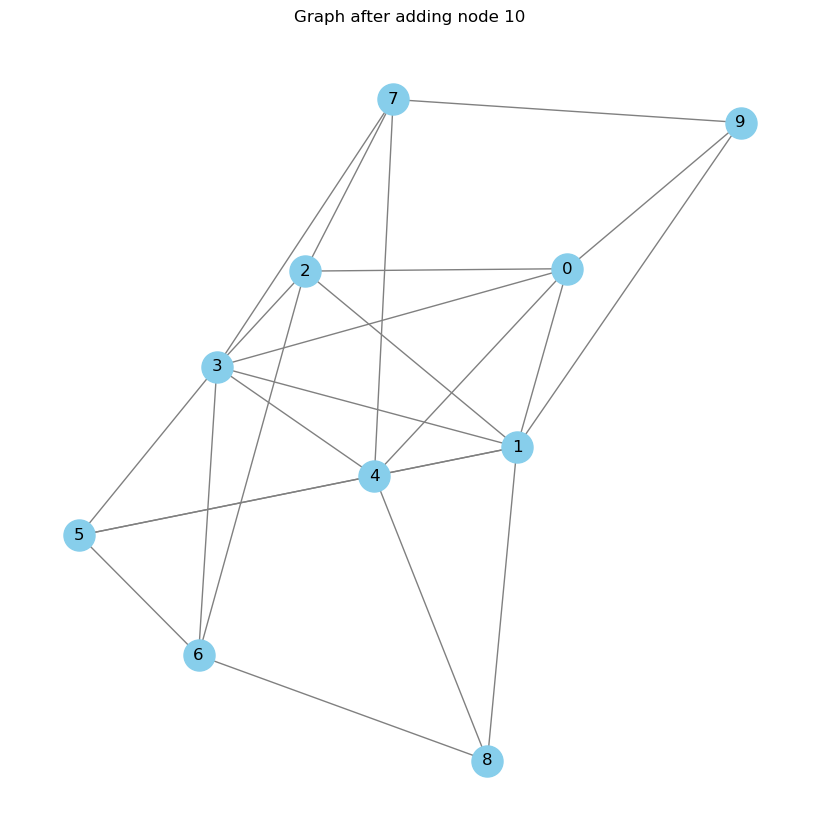

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def ba_scale_free_network_visualize(num_nodes: int, m: int):
    """
    创建一个无标度网络，使用Barabási–Albert模型，并逐步进行可视化。
    
    参数:
    - num_nodes: 网络中的节点总数
    - m: 每个新节点连接到的现有节点的数量

    返回:
    - g: 生成的无标度网络
    """
    assert m < num_nodes, "m must be less than num_nodes"

    # 初始化一个完全图，包含m个节点
    g = nx.complete_graph(m)

    # 节点的度的列表
    degrees = list(g.degree())

    # 初始可视化
    pos = nx.spring_layout(g)
    plt.figure(figsize=(8, 8))
    nx.draw(g, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
    plt.title("Initial Complete Graph")
    plt.show()

    # 计算初始图的平均路径长度和聚类系数
    if nx.is_connected(g):
        avg_path_length = nx.average_shortest_path_length(g)
    else:
        avg_path_length = float('inf')
    avg_clustering = nx.average_clustering(g)
    print(f"Initial Complete Graph - Avg Path Length: {avg_path_length}, Avg Clustering Coefficient: {avg_clustering}")

    for new_node in range(m, num_nodes):
        # 选择要连接的现有节点
        targets = set()
        while len(targets) < m:
            target = np.random.choice([node for node, degree in degrees])
            targets.add(target)
        
        # 添加新节点，并与选定的现有节点连接
        for target in targets:
            g.add_edge(new_node, target)
        
        # 更新度的列表
        degrees.extend([(new_node, 1)] * m)
        for target in targets:
            degrees.append((target, degrees[target][1] + 1))
        
        # 计算当前图的平均路径长度和聚类系数
        if nx.is_connected(g):
            avg_path_length = nx.average_shortest_path_length(g)
        else:
            avg_path_length = float('inf')
        avg_clustering = nx.average_clustering(g)
        print(f"After adding node {new_node + 1} - Avg Path Length: {avg_path_length}, Avg Clustering Coefficient: {avg_clustering}")
        
        # 可视化当前状态
        pos = nx.spring_layout(g)
        plt.figure(figsize=(8, 8))
        nx.draw(g, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray')
        plt.title(f"Graph after adding node {new_node + 1}")
        plt.show()

    return g

# 示例使用
num_nodes = 10
m = 3
g_scale_free = ba_scale_free_network_visualize(num_nodes, m)
